In [1]:
# import sentiment as sentimentinterface
import timeit
import numpy as np

import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
%matplotlib inline

In [2]:
def train_classifier(X, y):
    """Train a classifier using the given training data.

    Trains logistic regression on the input data with default parameters.
    """
    from sklearn.linear_model import LogisticRegression
    cls = LogisticRegression(random_state=0, solver='lbfgs', max_iter=10000)
    cls.fit(X, y)
    return cls

def evaluate(X, yt, cls, name='data'):
    """Evaluated a classifier on the given labeled data using accuracy."""
    from sklearn import metrics
    yp = cls.predict(X)
    acc = metrics.accuracy_score(yt, yp)
    print("  Accuracy on %s  is: %s" % (name, acc))

In [3]:
def read_files(tarfname):
    """Read the training and development data from the sentiment tar file.
    The returned object contains various fields that store sentiment data, such as:

    train_data,dev_data: array of documents (array of words)
    train_fnames,dev_fnames: list of filenames of the doccuments (same length as data)
    train_labels,dev_labels: the true string label for each document (same length as data)

    The data is also preprocessed for use with scikit-learn, as:

    count_vec: CountVectorizer used to process the data (for reapplication on new data)
    trainX,devX: array of vectors representing Bags of Words, i.e. documents processed through the vectorizer
    le: LabelEncoder, i.e. a mapper from string labels to ints (stored for reapplication)
    target_labels: List of labels (same order as used in le)
    trainy,devy: array of int labels, one for each document
    """
    import tarfile
    tar = tarfile.open(tarfname, "r:gz")
    trainname = "train.tsv"
    devname = "dev.tsv"
    for member in tar.getmembers():
        if 'train.tsv' in member.name:
            trainname = member.name
        elif 'dev.tsv' in member.name:
            devname = member.name


    class Data: pass
    sentiment = Data()
    print("-- train data")
    sentiment.train_data, sentiment.train_labels = read_tsv(tar,trainname)
    print(len(sentiment.train_data))

    print("-- dev data")
    sentiment.dev_data, sentiment.dev_labels = read_tsv(tar, devname)
    print(len(sentiment.dev_data))
    print("-- transforming data and labels")
    # Convert a collection of text documents to a matrix of token counts
    from sklearn.feature_extraction.text import CountVectorizer
    sentiment.count_vect = CountVectorizer()
    sentiment.trainX = sentiment.count_vect.fit_transform(sentiment.train_data)
    sentiment.devX = sentiment.count_vect.transform(sentiment.dev_data)
    from sklearn import preprocessing
    # Encode labels with value between 0 and n_classes-1.
    sentiment.le = preprocessing.LabelEncoder()
    sentiment.le.fit(sentiment.train_labels)
    sentiment.target_labels = sentiment.le.classes_
    sentiment.trainy = sentiment.le.transform(sentiment.train_labels)
    sentiment.devy = sentiment.le.transform(sentiment.dev_labels)
    tar.close()
    return sentiment


def new_read_files(tarfname,tfidf=True,min_df=1,max_df=1.0,ngram_range=(1,1)):

    import tarfile
    tar = tarfile.open(tarfname, "r:gz")
    trainname = "train.tsv"
    devname = "dev.tsv"
    for member in tar.getmembers():
        if 'train.tsv' in member.name:
            trainname = member.name
        elif 'dev.tsv' in member.name:
            devname = member.name
    class Data: pass
    sentiment = Data()
    print("-- train data")
    sentiment.train_data, sentiment.train_labels = read_tsv(tar,trainname)
    print(len(sentiment.train_data))

    print("-- dev data")
    sentiment.dev_data, sentiment.dev_labels = read_tsv(tar, devname)
    print(len(sentiment.dev_data))
    print("-- transforming data and labels")
    # Convert a collection of text documents to a matrix of token counts
    from sklearn.feature_extraction.text import CountVectorizer
    from sklearn.feature_extraction.text import TfidfVectorizer
    # stop_words=badwords,min_df=1,max_df=0.4
    
    if tfidf == False:
        sentiment.count_vect = CountVectorizer(min_df=min_df,max_df=max_df,ngram_range=ngram_range)
        sentiment.trainX = sentiment.count_vect.fit_transform(sentiment.train_data)
        sentiment.devX = sentiment.count_vect.transform(sentiment.dev_data)
    else:
        sentiment.count_vect = TfidfVectorizer(min_df=min_df,max_df=max_df,ngram_range=ngram_range)
        sentiment.trainX = sentiment.count_vect.fit_transform(sentiment.train_data)
        sentiment.devX = sentiment.count_vect.transform(sentiment.dev_data)

    from sklearn import preprocessing
    # Encode labels with value between 0 and n_classes-1.
    sentiment.le = preprocessing.LabelEncoder()
    sentiment.le.fit(sentiment.train_labels)
    sentiment.target_labels = sentiment.le.classes_
    sentiment.trainy = sentiment.le.transform(sentiment.train_labels)
    sentiment.devy = sentiment.le.transform(sentiment.dev_labels)
    tar.close()
    return sentiment

def read_tsv(tar, fname):
    member = tar.getmember(fname)
    print(member.name)
    tf = tar.extractfile(member)
    data = []
    labels = []
    toxic_count = 0
    not_toxic_count = 0
    batch_size = 20000
    for line in tf:
        line = line.decode("utf-8")
        if len(line.strip().split("\t")) != 2:
            continue
        (label,text) = line.strip().split("\t")
        if label=="TOXIC":
            toxic_count += 1
        else:
            not_toxic_count += 1
        labels.append(label)
        data.append(text)
        batch_size-=1
        if batch_size == 0:
            break
    print(member.name + " has {} TOXIC data and {} NOT_TOXIC data".format(toxic_count,not_toxic_count))
    return data, labels

In [4]:
print("Reading data")
tarfname = "data/sentiment.tar.gz"
sentiment0 = new_read_files(tarfname,tfidf=True,max_df=0.5)
print("~"*120)
sentiment1 = new_read_files(tarfname,tfidf=True,min_df=1,max_df=0.5,ngram_range=(1,2))

Reading data
-- train data
sentiment/train.tsv
sentiment/train.tsv has 0 TOXIC data and 4582 NOT_TOXIC data
4582
-- dev data
sentiment/dev.tsv
sentiment/dev.tsv has 0 TOXIC data and 458 NOT_TOXIC data
458
-- transforming data and labels
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
-- train data
sentiment/train.tsv
sentiment/train.tsv has 0 TOXIC data and 4582 NOT_TOXIC data
4582
-- dev data
sentiment/dev.tsv
sentiment/dev.tsv has 0 TOXIC data and 458 NOT_TOXIC data
458
-- transforming data and labels


In [17]:
print(sentiment0.train_data[4000]) # the first entry in training data
print(sentiment0.train_labels[4000])
print('~'*120)
print(sentiment0.train_data[1000])
print(sentiment0.train_labels[1000])



1.) crinkle cut fries!?!? come on, this reminds me of microwavable crinkle cut fries i used to eat back in the late 80's. makes the meal seem so cheap.2.) the
NEGATIVE
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Great people, great prices, great product. Very pleased with the Valentines Day help from this location. They were able to get what I wanted with little notice to make my
POSITIVE


In [18]:
sentiment = sentiment0
print(sentiment.trainX.shape[1])
print((sentiment.count_vect.get_feature_names()[8000])) # map id to word
print((sentiment.count_vect.get_feature_names()[1000]))

9880
slowly
beforehand


In [20]:
print('target labels ', sentiment0.target_labels)
print('target labels ', sentiment0.trainy[:5]) # show the labels of the first 5 training examples
print(list(sentiment0.le.classes_))
print(list(sentiment0.le.transform(['POSITIVE','NEGATIVE'])))
print(list(sentiment0.le.inverse_transform(list(sentiment0.trainy[:7]))))

target labels  ['NEGATIVE' 'POSITIVE']
target labels  [1 1 0 0 1]
['NEGATIVE', 'POSITIVE']
[1, 0]
['POSITIVE', 'POSITIVE', 'NEGATIVE', 'NEGATIVE', 'POSITIVE', 'NEGATIVE', 'NEGATIVE']


In [21]:
# from warnings import simplefilter
# import classify
# # ignore all future warnings
# simplefilter(action='ignore', category=FutureWarning)

cls0 = train_classifier(sentiment0.trainX, sentiment0.trainy)
evaluate(sentiment0.trainX, sentiment0.trainy, cls0, 'train')
evaluate(sentiment0.devX, sentiment0.devy, cls0, 'dev')

# trainCoeff = dict(zip(new_sentiment.count_vect.get_feature_names(), new_cls.coef_.flatten().tolist()))

  Accuracy on train  is: 0.9011348756001746
  Accuracy on dev  is: 0.7685589519650655


In [22]:
cls1 = train_classifier(sentiment1.trainX, sentiment1.trainy)
evaluate(sentiment1.trainX, sentiment1.trainy, cls1, 'train')
evaluate(sentiment1.devX, sentiment1.devy, cls1, 'dev')

  Accuracy on train  is: 0.9613705805325186
  Accuracy on dev  is: 0.7816593886462883


In [23]:
cls = cls0
sentiment = sentiment0
coefficients=cls.coef_[0]
print(cls.classes_)
print(cls.coef_)
print(cls.coef_.shape)
k = 20
# get top_k toxic coefficients -> positive coefficients tends to make prediction toxic
top_k =np.argsort(coefficients)[-k:]
top_k_words = []

print('-'*50)
print('Top k=%d' %k)
print('-'*50)

for i in top_k:
    print(sentiment.count_vect.get_feature_names()[i])
    top_k_words.append(sentiment.count_vect.get_feature_names()[i])

print('-'*50)
print('Bottom k=%d' %k)
print('-'*50)
#top_k = np.argpartition(coefficients, -k)[-k:]
bottom_k =np.argsort(coefficients)[:k]
bottom_k_words = []
#print(top_k)
for i in bottom_k:
    print(sentiment.count_vect.get_feature_names()[i])
    bottom_k_words.append(sentiment.count_vect.get_feature_names()[i])

#print(sentiment.count_ve

[0 1]
[[-0.55654368 -0.16308729 -0.06205979 ... -0.11592331 -0.11592331
  -0.11592331]]
(1, 9880)
--------------------------------------------------
Top k=20
--------------------------------------------------
definitely
vegas
wine
spot
good
little
loved
fantastic
always
wonderful
perfect
favorite
friendly
awesome
excellent
delicious
love
best
amazing
great
--------------------------------------------------
Bottom k=20
--------------------------------------------------
not
worst
horrible
terrible
rude
bad
went
disappointed
disappointing
star
ok
asked
awful
slow
average
overpriced
no
be
excited
but


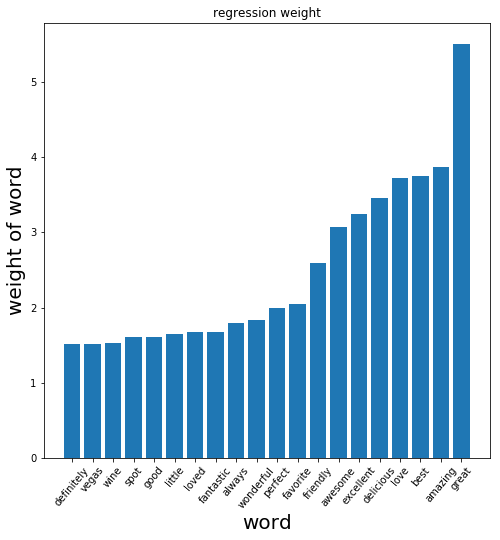

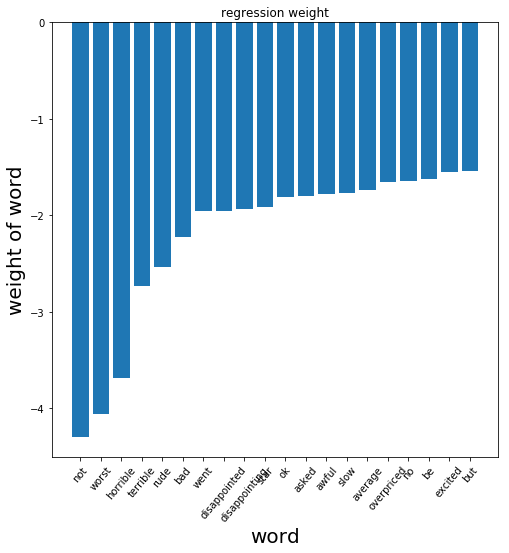

In [24]:
def plot_bar_x(k_words,_k,coeff):
    # this is for plotting purpose
    index = np.arange(len(k_words))
    wordsCoeff = []
    for i in _k:
        wordsCoeff.append(coeff[i])
    plt.figure(figsize=[8,8])
    plt.bar(index, wordsCoeff)
    plt.xlabel('word', fontsize=20)
    plt.ylabel('weight of word', fontsize=20)
    plt.xticks(index, k_words, fontsize=10, rotation=50)
    plt.title('regression weight')
    plt.show()
plot_bar_x(top_k_words, top_k, coefficients)
plot_bar_x(bottom_k_words, bottom_k, coefficients)

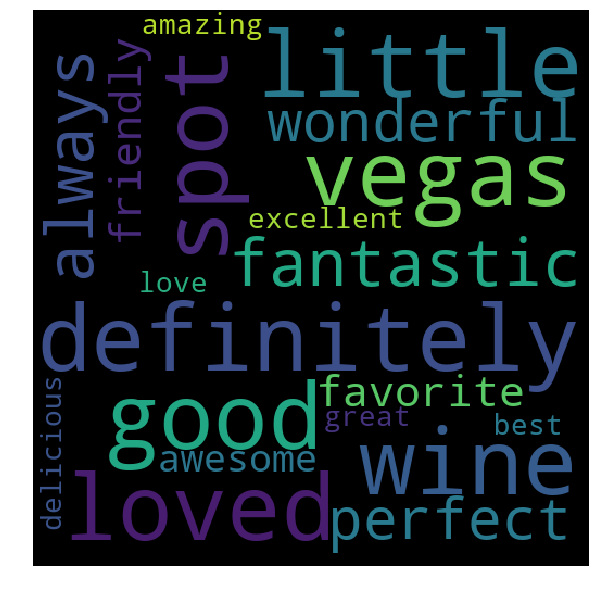

In [25]:
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
import random as random 
from PIL import Image
import urllib  
import requests

toxic_words = ''
for tw in top_k_words:
    toxic_words = toxic_words + tw + ' '

stopwords = set(STOPWORDS) 

wordcloud = WordCloud(width = 512, height = 512, 
                background_color ='black', 
                stopwords = stopwords, 
                min_font_size = 10).generate(toxic_words) 

  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 

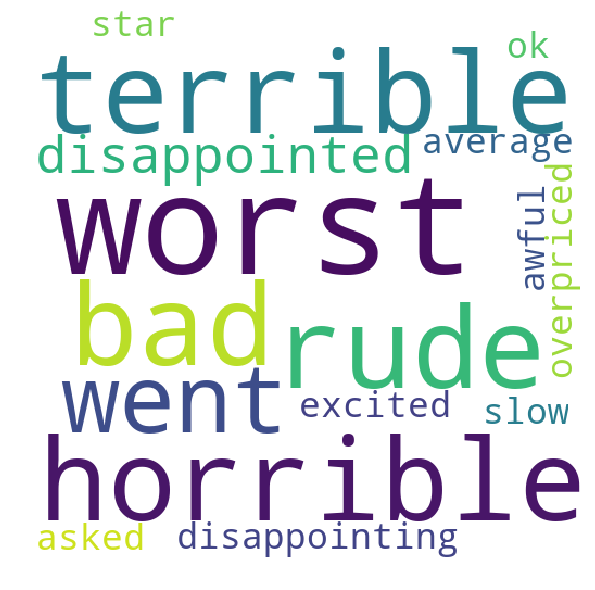

In [26]:
not_toxic_words = ''
for tw in bottom_k_words:
    not_toxic_words = not_toxic_words + tw + ' '

stopwords = set(STOPWORDS) 

wordcloud = WordCloud(width = 512, height = 512, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(not_toxic_words) 

  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 

  Accuracy on dev sentence with top k toxic words  is: 0.8177339901477833


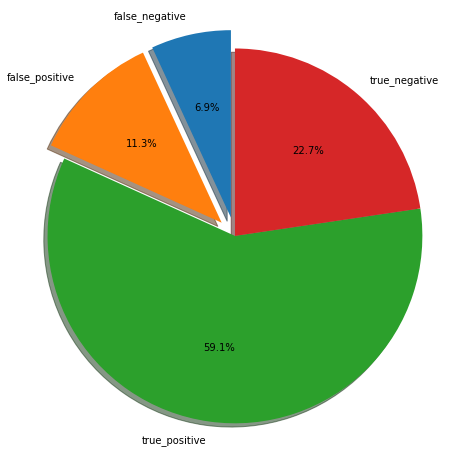

In [27]:
top_k_reviews = []
top_k_labels = []
for j in range(len(sentiment.dev_data)):
    review = sentiment.dev_data[j]
    for word in top_k_words:
        if word in review:
            top_k_reviews.append(review)
            top_k_labels.append(sentiment.dev_labels[j])
            break
    
dev_top_k_X = sentiment.count_vect.transform(top_k_reviews)
evaluate(dev_top_k_X, sentiment.le.transform(top_k_labels), cls, 'dev sentence with top k toxic words')

#=============================================================================================================

import matplotlib.pyplot as plt
y = cls.predict(dev_top_k_X)
yt = sentiment.le.transform(top_k_labels)
false_negative = 0
true_negative = 0 
false_positive = 0
true_positive = 0
for i in range(len(y)):
    if y[i]==1 and yt[i]==1:
        true_positive += 1
    elif y[i]==1 and yt[i]==0:
        false_positive += 1
    elif y[i]==0 and yt[i]==0:
        true_negative += 1
    else:
        false_negative += 1
        
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'false_negative', 'false_positive', 'true_positive' , 'true_negative'
sizes = [false_negative,  false_positive, true_positive, true_negative]
explode = (0.1, 0.1, 0, 0) 

fig1, ax1 = plt.subplots(figsize=(8,8))
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()


  Accuracy on dev sentence with bottom k non-toxic words  is: 0.76775956284153


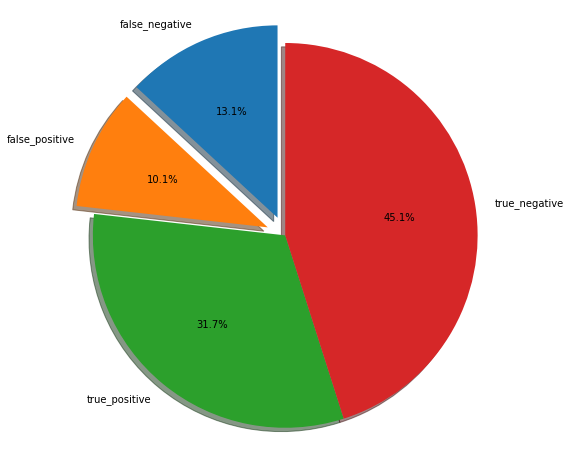

In [28]:
bottom_k_reviews = []
bottom_k_labels = []
for j in range(len(sentiment.dev_data)):
    review = sentiment.dev_data[j]
    for word in bottom_k_words:
        if word in review:
            bottom_k_reviews.append(review)
            bottom_k_labels.append(sentiment.dev_labels[j])
            break
    
dev_bottom_k_X = sentiment.count_vect.transform(bottom_k_reviews)
evaluate(dev_bottom_k_X, sentiment.le.transform(bottom_k_labels), cls, 'dev sentence with bottom k non-toxic words')

#=============================================================================================================

import matplotlib.pyplot as plt
y = cls.predict(dev_bottom_k_X)
yt = sentiment.le.transform(bottom_k_labels)
false_negative = 0
true_negative = 0 
false_positive = 0
true_positive = 0
for i in range(len(y)):
    if y[i]==1 and yt[i]==1:
        true_positive += 1
    elif y[i]==1 and yt[i]==0:
        false_positive += 1
    elif y[i]==0 and yt[i]==0:
        true_negative += 1
    else:
        false_negative += 1
        
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'false_negative', 'false_positive', 'true_positive' , 'true_negative'
sizes = [false_negative,  false_positive, true_positive, true_negative]
explode = (0.1, 0.1, 0, 0) 

fig1, ax1 = plt.subplots(figsize=(8,8))
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()


In [32]:
overconfident = []
overconfident_lab = []
overconfident_y = []
overconfident_yp = []
overconfident_index = []
y = cls.predict(sentiment.devX)
yp = cls.predict_proba(sentiment.devX)
yt = sentiment.devy
for j in range(len(sentiment.dev_data)):
    if y[j]!=yt[j] and (yp[j][0]>=0.9 or yp[j][1]>=0.9):
        overconfident.append(sentiment.dev_data[j])
        overconfident_lab.append(sentiment.dev_labels[j])
        overconfident_y.append(y[j])
        overconfident_yp.append(yp[j])
        overconfident_index.append(j)
# for ov in overconfident:
#     print(ov)

print(overconfident[-1])
print(overconfident_lab[-1])
print(overconfident_y[-1])
print(overconfident_yp[-1])

# help, idiots 

Having trouble on what to have for dinner and have a big appetite, Check out this place The desserts are great and so is the fresh food. I love coming
NEGATIVE
1
[0.09703623 0.90296377]
